In [1]:
import urllib.request
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics.pairwise import manhattan_distances

# =============================================================================
# 1. AYARLAR VE FONKSİYONLAR
# =============================================================================

URL_AUSTEN = "https://www.gutenberg.org/cache/epub/158/pg158.txt"  # Emma
URL_Bronte = "https://www.gutenberg.org/files/768/768-h/768-h.htm" # Wuthering Heights

def fetch_text(url):
    try:
        print(f"İndiriliyor: {url}...")
        req = urllib.request.Request(
            url,
            headers={'User-Agent': 'Mozilla/5.0'}
        )
        with urllib.request.urlopen(req) as response:
            raw_text = response.read().decode('utf-8-sig')
        start = raw_text.find("*** START OF")
        end = raw_text.find("*** END OF")
        if start != -1 and end != -1:
            return raw_text[start:end]
        return raw_text
    except Exception as e:
        print(f"Hata: {e}")
        return ""

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def make_chunks(text, chunk_size=100):
    tokens = text.split()
    chunks = []
    for i in range(0, len(tokens), chunk_size):
        chunk = " ".join(tokens[i:i+chunk_size])
        if len(chunk.split()) > 50: # Çok kısa artıklar atılır
            chunks.append(chunk)
    return chunks

In [2]:
# =============================================================================
# 2. VERİ HAZIRLIĞI
# =============================================================================

austen_full = clean_text(fetch_text(URL_AUSTEN))
Bronte_full = clean_text(fetch_text(URL_Bronte))

if not austen_full or not Bronte_full:
    print("HATA: Metinler indirilemedi. İnternet bağlantısını kontrol et.")
else:
    print("Metinler parçalanıyor (100 kelimelik bloklar)...")
    austen_docs = make_chunks(austen_full, chunk_size=100)
    Bronte_docs = make_chunks(Bronte_full, chunk_size=100)

    docs = austen_docs + Bronte_docs
    labels = np.array(["Austen"] * len(austen_docs) + ["Bronte"] * len(Bronte_docs))

    print(f"Eğitim Seti: {len(austen_docs)} Austen + {len(Bronte_docs)} Bronte parçası.")

İndiriliyor: https://www.gutenberg.org/cache/epub/158/pg158.txt...
İndiriliyor: https://www.gutenberg.org/files/768/768-h/768-h.htm...
Metinler parçalanıyor (100 kelimelik bloklar)...
Eğitim Seti: 1621 Austen + 1322 Bronte parçası.


In [3]:
# =============================================================================
    # 3. STİLOMETRİK MODEL (BURROWS' DELTA)
    # =============================================================================
    
print("\nModel eğitiliyor...")
vectorizer = CountVectorizer(max_features=50)
X_counts = vectorizer.fit_transform(docs)

normalizer = Normalizer(norm='l1')
X_freq = normalizer.fit_transform(X_counts)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_freq.toarray())


Model eğitiliyor...


In [4]:
# =============================================================================
    # 4. EŞİK DEĞERLERİ (THRESHOLDS)
    # =============================================================================

def get_author_stats(author_name, X_data, y_labels):
    indices = np.where(y_labels == author_name)[0]
    X_author = X_data[indices]
    centroid = X_author.mean(axis=0)
    dists = manhattan_distances(X_author, [centroid])

    threshold = dists.mean() + (3.0 * dists.std())
    return centroid, threshold

c_austen, t_austen = get_author_stats("Austen", X_scaled, labels)
c_Bronte, t_Bronte = get_author_stats("Bronte", X_scaled, labels)

print(f"Austen Kabul Sınırı: < {t_austen:.2f}")
print(f"Bronte Kabul Sınırı: < {t_Bronte:.2f}")


Austen Kabul Sınırı: < 52.31
Bronte Kabul Sınırı: < 47.33


In [5]:

    unknown_text = """
    In five minutes more the cloud of bewilderment dissolved: I knew quite well that I was in my own bed, and
that the red glare was the nursery fire. 
    """

    u_clean = clean_text(unknown_text)
    u_vec = vectorizer.transform([u_clean])
    u_freq = normalizer.transform(u_vec)
    u_scaled = scaler.transform(u_freq.toarray())

    d_austen = manhattan_distances(u_scaled, [c_austen])[0][0]
    d_Bronte = manhattan_distances(u_scaled, [c_Bronte])[0][0]

    print(f"\n--- TEST SONUCU ({len(unknown_text.split())} kelime) ---")
    print(f"Austen'a Uzaklık:   {d_austen:.2f}  (Sınır: {t_austen:.2f})")
    print(f"Bronte'e Uzaklık: {d_Bronte:.2f}  (Sınır: {t_Bronte:.2f})")


    in_austen = d_austen < t_austen
    in_Bronte = d_Bronte < t_Bronte

    print("\nSON KARAR:")
    if in_austen and not in_Bronte:
        print(">>> JANE AUSTEN <<<")
    elif in_Bronte and not in_austen:
        print(">>> Emily Bronte <<<")
    elif in_austen and in_Bronte:
        # İkisine de giriyorsa en yakını seç
        winner = "Austen" if d_austen < d_Bronte else "Bronte"
        print(f">>> {winner.upper()} <<< (İkisine de yakın, ama {winner} daha yakın)")
    else:
        # İkisine de girmiyorsa ama birine ÇOK yakında (1.5 kat sınır) esneklik tanı
        if d_austen < d_Bronte and d_austen < (t_austen * 1.5):
             print(">>> JANE AUSTEN <<< (Sınırda ama en güçlü aday)")
        elif d_Bronte < d_austen and d_Bronte < (t_Bronte * 1.5):
             print(">>> Emily Bronte <<< (Sınırda ama en güçlü aday)")
        else:
            print(">>> UNKNOWN (BİLİNMEYEN YAZAR) <<<")


--- TEST SONUCU (29 kelime) ---
Austen'a Uzaklık:   53.78  (Sınır: 52.31)
Bronte'e Uzaklık: 50.07  (Sınır: 47.33)

SON KARAR:
>>> Emily Bronte <<< (Sınırda ama en güçlü aday)


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

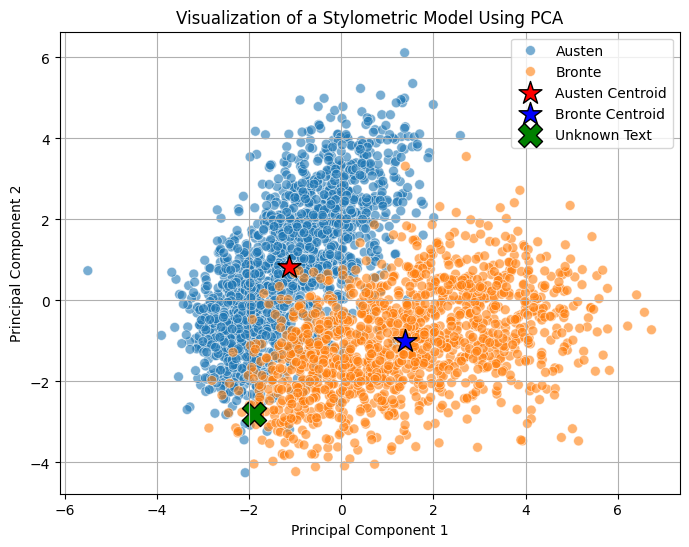

In [12]:
import pandas as pd

# PCA uygulayarak veriyi 2 boyuta indirgeyin
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Yazar merkezlerini ve bilinmeyen metni de PCA ile dönüştürün
c_austen_pca = pca.transform(c_austen.reshape(1, -1))[0]
c_Bronte_pca = pca.transform(c_Bronte.reshape(1, -1))[0]
u_scaled_pca = pca.transform(u_scaled)[0]

# Veri çerçevesi oluşturun
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Author'] = labels

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Author', data=df_pca, alpha=0.6, s=50)

# Yazar merkezlerini ekle
plt.scatter(c_austen_pca[0], c_austen_pca[1], marker='*', s=300, color='red', label='Austen Centroid', edgecolor='black')
plt.scatter(c_Bronte_pca[0], c_Bronte_pca[1], marker='*', s=300, color='blue', label='Bronte Centroid', edgecolor='black')

# Bilinmeyen metni ekle
plt.scatter(u_scaled_pca[0], u_scaled_pca[1], marker='X', s=300, color='green', label='Unknown Text', edgecolor='black')

plt.title('Visualization of a Stylometric Model Using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
# plt.show() komutundan hemen önce:
plt.savefig('delta_pca.png', dpi=300, bbox_inches='tight')
plt.show()

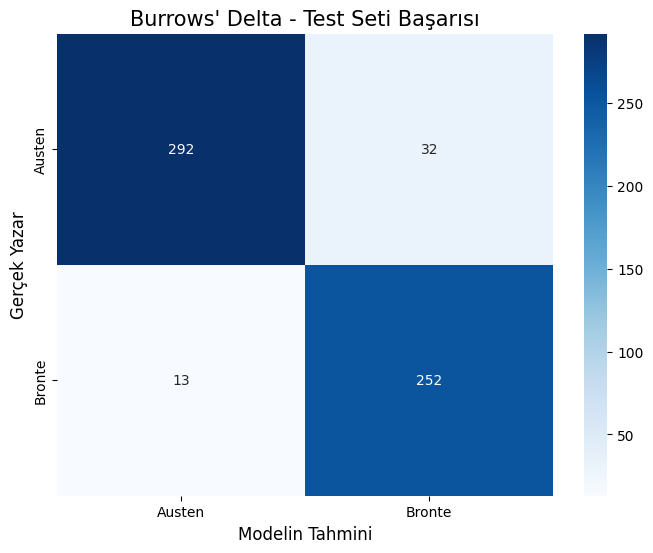

Test Seti Doğruluk Oranı (Accuracy): %92.36


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 5. MODEL BAŞARISI VE CONFUSION MATRIX
# ==========================================

# 1. Veriyi Eğitim ve Test olarak ayır (%20 Test)
# X_scaled ve labels değişkenleri yukarıdaki hücrelerden geliyor
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42, stratify=labels)

# 2. Eğitim setine göre Merkezleri (Centroid) yeniden hesapla
def get_centroid(X_data, y_data, author_name):
    indices = np.where(y_data == author_name)[0]
    return X_data[indices].mean(axis=0)

train_c_austen = get_centroid(X_train, y_train, "Austen")
train_c_bronte = get_centroid(X_train, y_train, "Bronte")

# 3. Test Seti Üzerinde Tahmin Yap (En yakın merkeze ata)
preds = []
for i in range(len(X_test)):
    # Test verisinin vektörü
    vec = X_test[i].reshape(1, -1)
    
    # Her iki merkeze uzaklığı ölç (Manhattan Distance / L1 Norm)
    dist_austen = manhattan_distances(vec, [train_c_austen])[0][0]
    dist_bronte = manhattan_distances(vec, [train_c_bronte])[0][0]
    
    # Hangisi yakınsa onu seç
    if dist_austen < dist_bronte:
        preds.append("Austen")
    else:
        preds.append("Bronte")

# 4. Confusion Matrix Oluştur
cm = confusion_matrix(y_test, preds, labels=["Austen", "Bronte"])

# 5. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Austen", "Bronte"],
            yticklabels=["Austen", "Bronte"])

plt.title('Burrows\' Delta - Test Seti Başarısı', fontsize=15)
plt.xlabel('Modelin Tahmini', fontsize=12)
plt.ylabel('Gerçek Yazar', fontsize=12)
plt.show()

# Başarı oranını da yazdıralım
accuracy = np.trace(cm) / np.sum(cm)
print(f"Test Seti Doğruluk Oranı (Accuracy): %{accuracy*100:.2f}")

In [9]:
from sklearn.metrics import accuracy_score, f1_score

# y_test: Gerçek yazarlar
# preds: Senin modelinin tahminleri (kodunda bu değişken 'preds' olarak geçiyor)

# Accuracy Hesapla
acc = accuracy_score(y_test, preds)

# F1 Score Hesapla (Macro average dengeli olduğu için idealdir)
f1 = f1_score(y_test, preds, average='macro')

print(f"Tabloya yazılacak Accuracy: {acc:.2f}")
print(f"Tabloya yazılacak F1-Score: {f1:.2f}")

Tabloya yazılacak Accuracy: 0.92
Tabloya yazılacak F1-Score: 0.92


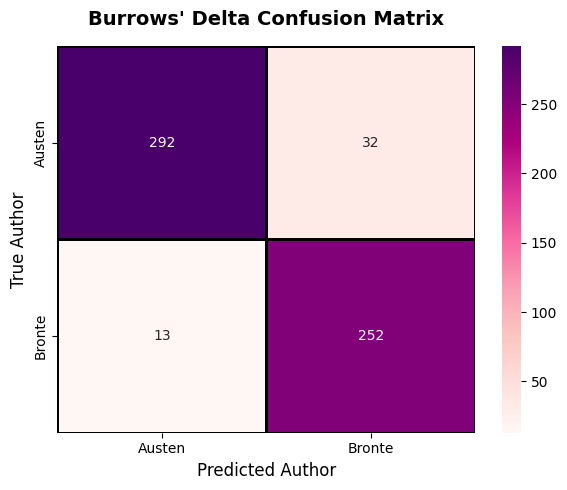

Grafik 'delta_confusion.png' olarak kaydedildi!


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Confusion Matrix Hesapla
# y_test (gerçek) ve preds (tahmin) değişkenleri notebook'ta zaten tanımlı.
# labels=['Austen', 'Bronte'] diyerek sırayı sabitliyoruz.
cm_delta = confusion_matrix(y_test, preds, labels=['Austen', 'Bronte'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_delta, 
            annot=True, 
            fmt='d', 
            cmap='RdPu',       # İSTEDİĞİN RENK (Red-Purple)
            xticklabels=['Austen', 'Bronte'], 
            yticklabels=['Austen', 'Bronte'],
            linewidths=1, 
            linecolor='black')

plt.title("Burrows' Delta Confusion Matrix", fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Author', fontsize=12)
plt.xlabel('Predicted Author', fontsize=12)
plt.tight_layout()

# Kaydet
plt.savefig('delta_confusion.png', dpi=300)
plt.show()

print("Grafik 'delta_confusion.png' olarak kaydedildi!")